In [1]:
#데이터 구성: series, dataframe
import pandas as pd

#행렬 연산
import numpy as np

#데이터 시각화
import matplotlib.pyplot as plt
import matplotlib

#scaling
from sklearn.preprocessing import StandardScaler

#데이터 분할:train, test
from sklearn.model_selection import train_test_split

#로지스틱 회귀
from statsmodels.api import Logit

#평가함수
from sklearn.metrics import accuracy_score

#confusion matrix
from sklearn.metrics import confusion_matrix

In [2]:
#맑은 고딕 적용
matplotlib.rc('font', family = 'Malgun Gothic')

In [3]:
#데이터 구성
df_raw = pd.read_csv("/home/piai/test/HMEQ.csv",engine = 'python', encoding='cp949')
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [4]:
#데이터 전처리-결측치 처리
df_raw.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [6]:
#fillna: 결측치 대체 함수
#JOB 변수의 결측치는 'other'로 대체, inplace:fillna 함수 적용 후 df_raw 데이터에 저장, False면 저장 안함
df_raw['JOB'].fillna('Other', inplace=True)
#숫자형 변수의 결측치는 해당 변수의 평균값 입력: df_raw.mean()각 변수별 평균 계산 후 결측치 대체
df_raw.fillna(df_raw.mean(), inplace=True)

In [8]:
#데이터 분할(train, test 데이터 7:3 비율로 분할)
df_train, df_test = train_test_split(df_raw, test_size=0.3, random_state =1234)

print('train data size:{}'.format(df_train.shape))
print('test data size:{}'.format(df_test.shape))

train data size:(2623, 13)
test data size:(1125, 13)


In [9]:
#모델 및 회귀계수 검토
#from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula('BAD ~ LOAN + MORTDUE + VALUE + C(REASON)+ C(JOB) +YOJ + DEROG+DELINQ+CLAGE+NINQ+CLNO+DEBTINC', df_train)

#적합
log_result = log_model.fit()

#결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Thu, 19 Nov 2020   Pseudo R-squ.:                  0.2257
Time:                        11:47:28   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.0942      0.560     -9.100      0.000      -6.191      -3.997

#모델 및 회귀계수 검토
1. 전체 자료 수:2623
2. 잔차 자유도: 2606
3. 모델 자유도: 16

설명력: 0.2257 (로지스틱 회귀분석의 설명력은 낮음)

회귀계수 검정 -> 유의수준 0.05에서 유의한 변수, 변수JOB은 유의하다고 판단할 수 있음

In [10]:
#예측 및 성능 평가

#예측

#test 데이터 예측
y_pred = log_result.predict(df_test)

#0과1의 값을 가진 class로 변환
y_pred_class = (y_pred >0.5).astype(int)
y_pred_class.head()

1721    0
822     0
1686    0
789     0
165     0
dtype: int64

In [11]:
#평가
#실제 test 데이터의 목표변수와 test 데이터의 예측값 비교
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test['BAD'], y_pred_class)))
print('Confusion Matrix: \n{}'.format(confusion_matrix(df_test['BAD'], y_pred_class)))

Accuracy: 0.924

Confusion Matrix: 
[[1017    4]
 [  81   23]]


In [12]:
#모델의 정분류율은 92.4

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


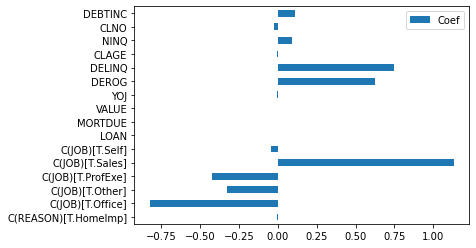

In [13]:
#결론 도출 - 최종 회귀식

#설명변수 중요도
df_logistic_coef = pd.DataFrame({'Coef':log_result.params.values[1:]}, index=log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = 'Coef')

In [16]:
#결론 도출 - 표준화 회귀 계수

#select_dtypes: 특정 변수 타입을 선택/제외하여 데이터 추출
df_char = df_raw.select_dtypes(include='object')
df_numeric = df_raw.select_dtypes(exclude = 'object')

#Data Scaling
scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns=df_numeric.columns)

#문자 데이터 + 숫자 데이터
df_scaled = pd.concat([df_numeric_scaled, df_char],axis =1)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,3.140664,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,3.140664,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,-0.318404,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,3.140664,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,-0.318404,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [17]:
#BAD 변수도 scaling 적용(scale 대상에서 제외하거나 1/0으로 재변환 필요)

In [18]:
#BAD 데이터를 0과 1로 변환, np.where(조건, 조건을 만족하는 경우, 만족하지 않는 경우)
df_scaled['BAD'] = np.where(df_scaled['BAD']>0, 1,0)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,0,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,1,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,0,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [22]:
#데이터 분할
df_scaled_train, df_scaled_test = train_test_split(df_scaled, test_size=0.3, random_state=1234)

#from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula('BAD ~ LOAN + MORTDUE + VALUE + C(REASON)+ C(JOB) +YOJ + DEROG+DELINQ+CLAGE+NINQ+CLNO+DEBTINC', df_scaled_train)

#적합
scaled_log_result = scaled_log_model.fit()

#결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Thu, 19 Nov 2020   Pseudo R-squ.:                  0.2257
Time:                        13:39:23   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.4815      0.205    -12.111      0.000      -2.883      -2.080

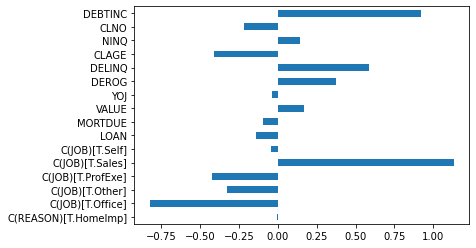

In [23]:
#결론 도출 - 표준화 회귀 계수

#설명변수 중요도
df_log_scaled_coef = pd.DataFrame({'Coef':scaled_log_result.params.values[1:]}, index = scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y='Coef', legend=False)